Para simplificar el problema:
- voy a limitarme a captchas de 4 caracteres alfanuméricos.
- letras mayúsculas y números entre 1 y 9 (el "0" es imposible de distinguir el "0" de una "o" mayúscula incluso para el ojo humano).
- limitado a un solo tipo de fuente (los captchas suelen utilizar distintos tipos de fuente para hacer más difícil distinguir los caracteres).

- estos captchas los generaré usando la de python
    https://pypi.org/project/captcha/

- TO-DO incluir letras mayúsculas y minúsculas (algunas, como la "v", "w", "x", "y" u "o" son muy difíciles de distinguir incluso para el ojo humano). También es muy difícil distinguir "1" de "l" minúscula.
- TO-DO captchas con distintos tipos de fuentes.
- TO-DO captchas con un número variable de caracteres.

- las imágenes se guardan en el directorio `input` como gráficos .PNG, el nombre del archivo es el texto que está oculto en la imagen.
- a partir de las imágenes se separan las letras que se utilizarán como entrenamiento para una red neuronal.

# Parte 1
Generar imágenes usando:
    https://pypi.org/project/captcha/
    
Imágenes de 4 caracteres.

# Parte 2
Entrenar una red neuronal.

## Parte 2.1
Separar el captcha en 4 trozos correspondientes a los 4 caracteres.

Cada uno de esos caracteres (imágenes) para todas las imágenes seleccionadas serán con lo que se entrene la red neuronal. El objetivo es conseguir diferentes variaciones de cada letra o número.

Esto no es tan fácil como separar la imagen en trozos del mismo tamaño porque los caracteres en un captcha las letras tienen diferentes tamaños, aparecen giradas, y desplazadas en posiciones aleatorias de modo que en muchos casos se solapan.

Esto lo haré usando la librería OpenCV.
## Parte 2.2
Entrenar una red neuronal.


EZHQ


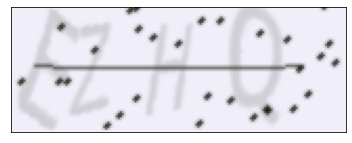

Setup completado!


In [76]:
import cv2
import pytesseract
import numpy as np
import os
import re
from pytesseract import Output
from matplotlib import pyplot as plt
from PIL import Image


#captcha_image_filename = 'input/captchas_dataset/train_data/1BCS.png'
#captcha_image_filename = 'input/captchas_dataset/train_data/DXOJ.png'
captcha_image_filename = 'input/captchas_dataset/train_data/EZHQ.png'

filename = os.path.basename(captcha_image_filename)
captcha_correct_text = re.sub("\.png$", "", filename)
print(captcha_correct_text)


def show(img):
    plt.imshow(img, cmap='Greys')
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()


# Cargar la imagen:
image = cv2.imread(captcha_image_filename)

show(image)

print("Setup completado!")

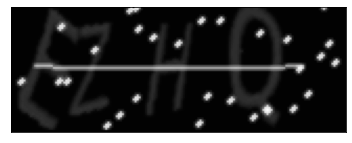

In [77]:
# Paso la imagen a blanco y negro
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

show(image)

## Smoothing de la imagen para ayudar a separar los caracteres
https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html

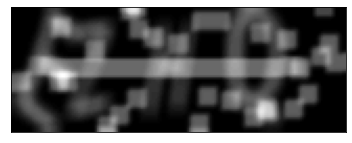

In [78]:
# smoothing the image with Homogeneus Blur
MAX_KERNEL_LENGTH = 10

for i in range(1, MAX_KERNEL_LENGTH, 2):
    dst = cv2.blur(image.copy(), (i, i))
show(dst)

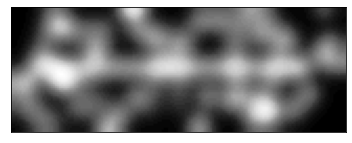

In [79]:
# smoothing the image Gaussian Blur
MAX_KERNEL_LENGTH = 31
for i in range(1, MAX_KERNEL_LENGTH, 2):
    dst = cv2.GaussianBlur(image.copy(), (i, i), 0)
show(dst)

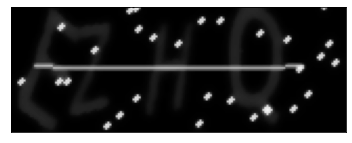

In [80]:
# smoothing the image Bilateral Filter
MAX_KERNEL_LENGTH = 10

for i in range(1, MAX_KERNEL_LENGTH, 2):
    dst = cv2.bilateralFilter(image.copy(), i, i * 2, i / 2)
show(dst)

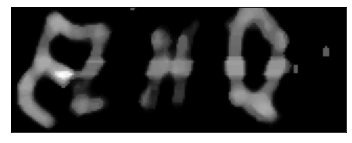

In [81]:
# smoothing the image Median Blur
MAX_KERNEL_LENGTH = 10

for i in range(1, MAX_KERNEL_LENGTH, 2):
    dst = cv2.medianBlur(image.copy(), i)
show(dst)

### La mejor opción es *image Median Blur*
Tengo que probar pasando primero un MedianBlur y luego otros filtros de estos para quitar más ruido si se puede.

## Pasamos la imagen a blanco y negro
Basándonos en la imagen que ha quedado del Median Blur

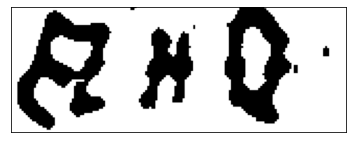

In [82]:
thresh = cv2.adaptiveThreshold(dst.copy(), 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,91,2)
show(thresh)

## Prueba con Tesseract a ver que tal distingue letras un OCR
Ya que tenemos todas las letras más o menos separadas, vamos a ver cómo se comporta un OCR.

Parece que no distingue las letras demasiado bien:

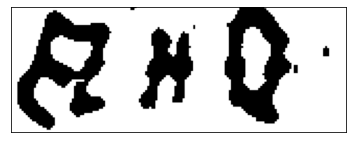

In [83]:
# Las opciones que he usado para Tesseract
# - psm 11: page segmentation modes. selecciono 7: trata la imagen como si fuese una única línea de texto. 
# - oem 1: OCR engine mode. Selecciono 1: Neural nets LSTM engine only
# - tessedit_char_whitelist: ignora los caracteres que no estén en esta lista

custom_config = '--psm 12 --oem 1 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
ocr_result = pytesseract.image_to_string(thresh, config=custom_config)
show(thresh)


In [84]:
# No da muy buen resultado
print("Resultado: ", ocr_result)

Resultado:  OBY



## Buscamos los contornos de cada letra con Open CV
**importante** cuando tenga todas las letras tengo que comprobar si el set de datos está balanceado (si hay más o menos el mismo número de cada letra).

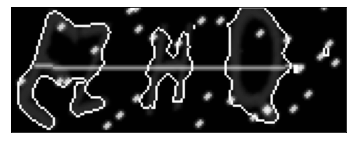

In [85]:

img = image.copy()

# Extraemos los contornos de las letras:
#contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img, contours, -1, (0,255,0), 1)

show(img)

[(61, 10, 26, 39), (102, 0, 32, 56), (3, 2, 22, 57), (25, 2, 22, 57)]


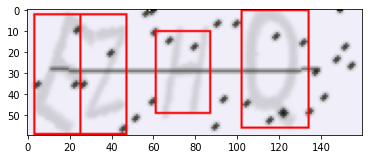

In [87]:
# A partir del contorno extraemos el rectángulo de cada letra:
letter_image_regions = []

img = thresh.copy()

for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    
    # me quedo con las regiones que tienen un área de mas de 500px² porque si es más pequeña es probable que se trate de una agrupación de puntos y no de una letra
    area = w * h    
    if area > 500:
        letter_image_regions.append((x, y, w, h))
    
    #if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
    #    half_width = int(w / 2)
    #    letter_image_regions.append((x, y, half_width, h))
    #    letter_image_regions.append((x + half_width, y, half_width, h))
    #else:
        # This is a normal letter by itself
    #    letter_image_regions.append((x, y, w, h))
    
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)

# Si hay menos regiones que letras (recuerda que son 4 letras por captcha) es que algún par se ha confundido.
# Hay que separar este par de letras "siamesas". Las que más probabilidades es la que tiene el área más grande.
if len(letter_image_regions) < 4:
    # ordeno los cuadrados por área
    sorted_letter_image_regions = sorted(letter_image_regions, key=lambda x: x[2] * x[3], reverse = True)
    largest_region = sorted_letter_image_regions[0]
    #print(largest_region)
    # divido la región más grande por anchura
    x, y, w, h = largest_region
    half_width = w // 2
    letter_image_regions.append((x, y, half_width, h))
    letter_image_regions.append((x + half_width, y, half_width, h))
    
    # Quito la región original que he dividido en dos
    letter_image_regions.remove(largest_region)

# Pinto los rectángulos sobre la imagen:
image_color = cv2.imread(captcha_image_filename)
img = image_color.copy()
for region in letter_image_regions:
    x, y, w, h = region
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)

plt.imshow(img)

print(letter_image_regions)